<a href="https://colab.research.google.com/github/MarkAvilin1/DS-and-ML/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ultra Pro задание

Возьмите базу трафика с сайта компании. Напишите модель для прогнозирования трафика. 

Возьмите xLen = 60. 

Добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
base_data = pd.read_csv('/content/drive/My Drive/traff.csv')
base_data.head()

,1/1/2017,"22,226.00"
0,1/2/2017,"29,593.00"
1,1/3/2017,"31,726.00"
2,1/4/2017,"32,684.00"
3,1/5/2017,"31,820.00"
4,1/6/2017,"29,354.00"


In [ ]:
# Убираем ненужную колонку с датой
base_data = base_data.iloc[:,1:]
base_data.columns = ['traff']
base_data.head()

,traff
0,"29,593.00"
1,"31,726.00"
2,"32,684.00"
3,"31,820.00"
4,"29,354.00"


In [ ]:
# Удаляем ненужный символ ','
a = []
for i in range(len(base_data)):
    
    a.append(float(base_data['traff'][i].replace(',','')))

In [ ]:
index = list(range(len(base_data)))
data = pd.DataFrame(a, columns = ['traff'], index = index)
data

,traff
0,29593.0
1,31726.0
2,32684.0
3,31820.0
4,29354.0
...,...
1089,29801.0
1090,34913.0
1091,37665.0
1092,32643.0


In [ ]:
data.shape

(1094, 1)

In [ ]:
xLen = 60
valLen = 300 

trainLen = data.shape[0]-valLen 

xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain,yTest = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

trainDataGen = TimeseriesGenerator(xTrain, yTrain, 
                               length=xLen, sampling_rate=1, 
                               batch_size=20)                

testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)
print(trainDataGen[0][0].shape)

(794, 1)
(238, 1)
(794, 1)
(238, 1)
(20, 60, 1)


## Визуализация результатов

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)  
  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
def correlate(a, b):
  ma = a.mean() 
  mb = b.mean()
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std()   
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0] 
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))
    own_corr = [] 
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()



DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Модель

Epoch 1/10
37/37 [==============================] - 1s 30ms/step - loss: 9.9848 - val_loss: 1.0169
Epoch 2/10
37/37 [==============================] - 1s 27ms/step - loss: 0.3279 - val_loss: 0.0367
Epoch 3/10
37/37 [==============================] - 1s 27ms/step - loss: 0.0257 - val_loss: 0.0073
Epoch 4/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0089 - val_loss: 0.0066
Epoch 5/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 6/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0078 - val_loss: 0.0164
Epoch 7/10
37/37 [==============================] - 1s 27ms/step - loss: 0.0125 - val_loss: 0.0166
Epoch 8/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 9/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 10/10
37/37 [==============================] - 1s 27ms/step - loss: 0.0050 - val_loss: 0.0039


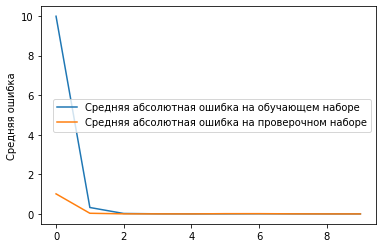

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(2048, 5, input_shape = (xLen,1), activation='linear'))
modelC.add(Flatten())
modelC.add(Dense(2048, activation='linear'))
modelC.add(Dense(1, activation='linear'))

modelC.compile(loss='mse', optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(
                    trainDataGen,
                    epochs=10, verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

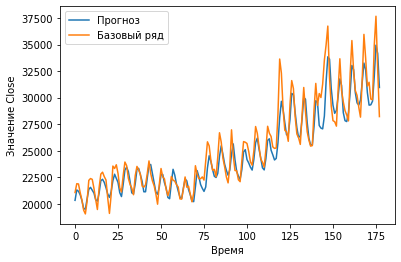

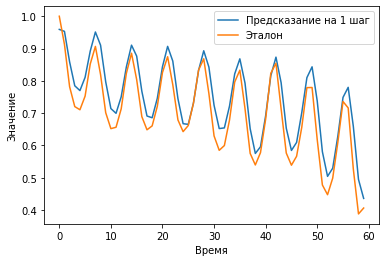

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)


showPredict(0, 4000, 0, predVal, yValUnscaled)

showCorr([0], 60, predVal, yValUnscaled)